In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../images_video/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



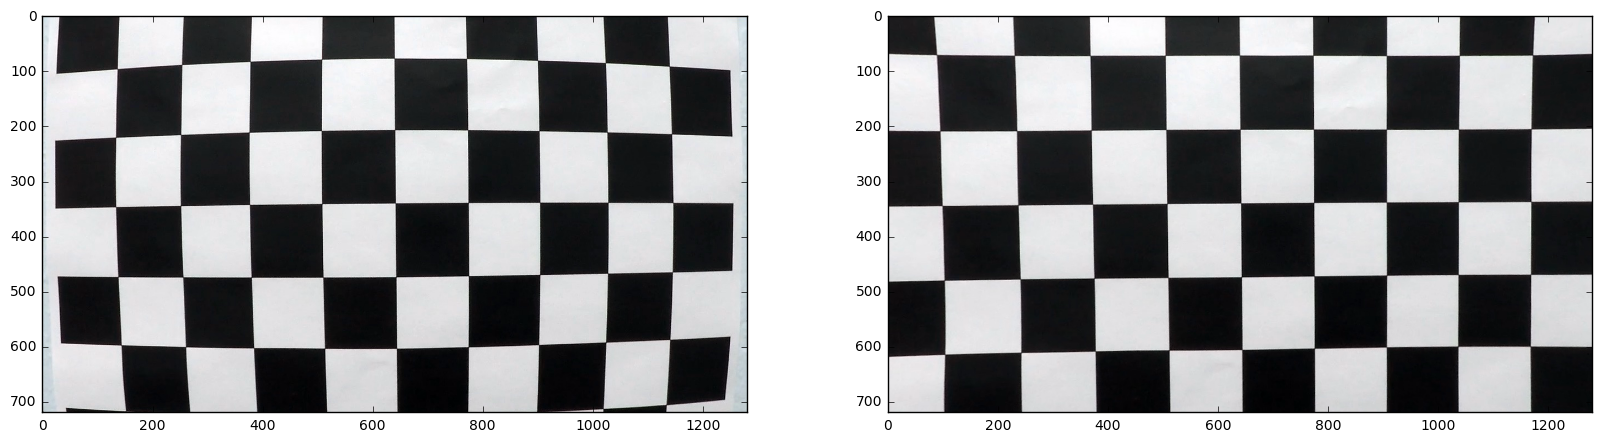

In [2]:
import pickle
%matplotlib inline

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Test undistortion on an image
img = cv2.imread('../images_video/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../images_video/cal1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(dst)

In [3]:
# Define some functions to do perspective transform

def warper(binary_img):

    # Define calibration box in source (actual) and destination (desired) coordinates
    img_size = (binary_img.shape[1], binary_img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 25, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 50), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])

    # Compute and apply perpective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv =  cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return Minv, warped

# Define a function to take x,y vectors of arbitrary length and warp to new space given transform matrix M
def warp_points(x, y, M):
    # Expect x and y to be vectors and transform matrix M to be a 3x3
    xnew = (M[0][0]*x + M[0][1]*y + M[0][2])/(M[2][0]*x + M[2][1]*y + M[2][2])
    ynew = (M[1][0]*x + M[1][1]*y + M[1][2])/(M[2][0]*x + M[2][1]*y + M[2][2])
    
    return xnew, ynew

In [4]:
def region_of_interest(img, vertices):
    
    # Define a blank mask to start with
    mask = np.zeros(img.shape, np.float) 
    
    # Define a 3 channel or 1 channel fill color
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,)*channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask.astype(img.dtype))
    return masked_image

def find_newgood(nzerox, nzeroy, startind, stopind, width, fit):
    
    # Extrapolate a fit to the lane line to include new pixels
    fitdeg = len(fit) - 1
    if fitdeg == 2:
        xfit = fit[0]*nzeroy**2 + fit[1]*nzeroy + fit[2]
    elif fitdeg == 1:
        xfit = fit[0]*nzeroy + fit[1] 
    good = ((nzerox >= (xfit - width)) \
                    & (nzerox <= (xfit + width)) \
                    & (nzeroy > startind) \
                    & (nzeroy <= stopind)).nonzero()[0]
    return good

def line_search(nzx, nzy, px, ystart_frac, startind, img_shape, margin):
    
    # Identify pixels associated with the base of the line (bottom of the image)
    good1 = ((nzx >= px[0]) & (nzx <= px[1]) & (nzy >= startind)).nonzero()[0]
    nonzero1x = nzx[good1]  
    nonzero1y = nzy[good1]    

    # Define the starting point for bins in y to iteratively find the lines
    next_ysfrac = ystart_frac - 0.1
    last_ysfrac = 0
    nsteps = 1 + next_ysfrac/0.1
    ystarts = np.linspace(next_ysfrac, last_ysfrac, nsteps, endpoint=True)
    dy = 1 - ystart_frac # y bin size
   
    for ys in ystarts:  # step through the bins in y
        
        order = 1    # order of the polynomial fit        
        line1 = np.polyfit(nonzero1y, nonzero1x, order) # fit a line to pixels in the base of left line
        startind = round(img_shape[0]*ys)   # start point of y bin
        stopind = round(img_shape[0]*(ys+dy))  # end point of y bin
        #select new set of pixels to add to the line
        new_good1 = find_newgood(nzx, nzy, startind, stopind, margin, line1)  
        if len(new_good1) > 0:  #if we found some, add them to the line
            if len(new_good1) > 10: #if we found more than 10 use them to define next line segment selection
                nonzero1x = nzx[new_good1]
                nonzero1y = nzy[new_good1]
            
            good1 = np.hstack((good1, new_good1))    
        
    
    # Get rid of duplicates from overlapping bins
    return np.unique(good1)

# Define the main function for finding the lines, either based on previous detection or blind search
def find_line_pixels(binimg):
    
    # Define some parameters for line search, if lines not already detected
    img_shape = binimg.shape
    search_smooth = 11
    ystart_frac = 0.5
    ymid = np.int(img_shape[0]/2)
    xmid = np.int(img_shape[1]/2)
    
    margin = 50 # width to include pixels left and right of the fit
    min_detected_pixels = 10 #arbitrary cutoff for minimum number of pixels defining a line
    
    # Identify all nonzero pixels in the binary image
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # If the left line was detected in the previous frame, search for new detection within +/- margin in x
    if left_line.detected:
        leftfit = left_line.best_fit
        # Identify all pixels associated with the lines
        good_inds = ((nonzerox > (leftfit[0]*(nonzeroy**2) + leftfit[1]*nonzeroy + leftfit[2] - margin)) & \
                    (nonzerox < (leftfit[0]*(nonzeroy**2) + leftfit[1]*nonzeroy + leftfit[2] + margin)))  
        
        if len(good_inds) > min_detected_pixels: 
            left_line.allx = nonzerox[good_inds]
            left_line.ally = nonzeroy[good_inds]
            left_fit = np.polyfit(left_line.ally, left_line.allx, 2)
            left_line.detected = True
        else:
            left_line.detected = False
      
    else: 
        # Search the lower left quadrant of the image for the left line base
        print('initializing search for left line...')
        counts = np.sum(binimg[ymid:, 0:xmid], axis=0) #histogram of hot pixels in each column of pixels
        smooth_counts = np.convolve(counts, np.ones(search_smooth)/search_smooth, mode='same') #boxcar smooth
        line_cen = np.argmax(smooth_counts)
        pleftx = [line_cen - margin, line_cen + margin]
        good_inds = line_search(nonzerox, nonzeroy, pleftx, ystart_frac, ymid, img_shape, margin)                

        if len(good_inds) > min_detected_pixels: 
            left_line.allx = nonzerox[good_inds]
            left_line.ally = nonzeroy[good_inds]
            left_fit = np.polyfit(left_line.ally, left_line.allx, 2)
            left_line.detected = True
        else:
            left_line.detected = False

    # If the right line was detected in the previous frame, search for new detection within +/- margin in x
    if right_line.detected:        
        rightfit = right_line.best_fit
        # Identify all pixels associated with the lines
        good_inds = ((nonzerox > (rightfit[0]*(nonzeroy**2) + rightfit[1]*nonzeroy + rightfit[2] - margin)) & \
                     (nonzerox < (rightfit[0]*(nonzeroy**2) + rightfit[1]*nonzeroy + rightfit[2] + margin)))
        if len(good_inds) > min_detected_pixels: 
            right_line.allx = nonzerox[good_inds]
            right_line.ally = nonzeroy[good_inds]
            right_fit = np.polyfit(right_line.ally, right_line.allx, 2)
            right_line.detected = True
        else:
            right_line.detected = False
      
    else: 
        # Search the lower left quadrant of the image for the left line base
        print('initializing search for the right line...')
        counts = np.sum(binimg[ymid:, xmid:], axis=0) #histogram of hot pixels in each column of pixels
        smooth_counts = np.convolve(counts, np.ones(search_smooth)/search_smooth, mode='same') #boxcar smooth
        line_cen = np.argmax(smooth_counts) + xmid
        prightx = [line_cen - margin, line_cen + margin]
        good_inds = line_search(nonzerox, nonzeroy, prightx, ystart_frac, ymid, img_shape, margin)                

        if len(good_inds) > min_detected_pixels: 
            right_line.allx = nonzerox[good_inds]
            right_line.ally = nonzeroy[good_inds]
            right_fit = np.polyfit(right_line.ally, right_line.allx, 2)
            right_line.detected = True
        else:
            right_line.detected = False
            

    recent_detections = 10 #an arbitrary number of recent detections to take into consideration when deciding
                            #whether a new detection is an outlier
    if left_line.detected:
        
        # Take the difference in fit coefficients between last fit and new fit
        diff_left = np.absolute(left_line.current_fit - left_fit)
        left_line.diffs = np.vstack((left_line.diffs, diff_left))
        
        # If we have enough data do the outlier rejection step
        if left_line.diffs.shape[0] > recent_detections:
            left_std = np.std(left_line.diffs[:,0])
            left_line.diffs = left_line.diffs[-recent_detections:]
            
            # Reject outliers where quadratic term of the fit is > 4 standard devs from best fit
            if diff_left[0] < 4*left_std:
                left_line.current_fit = left_fit
        else:
            left_line.current_fit = left_fit
     
    if right_line.detected:
        
        # Take the difference in fit coefficients between last fit and new fit
        diff_right = np.absolute(right_line.current_fit - right_fit)
        right_line.diffs = np.vstack((right_line.diffs, diff_right))
                    
        if right_line.diffs.shape[0] > recent_detections:
            right_std = np.std(right_line.diffs[:,0])
            right_line.diffs = right_line.diffs[-recent_detections:]
            if diff_right[0] < 4*right_std:
                right_line.current_fit = right_fit                
        else:
            right_line.current_fit = right_fit

        
    sample_loc = img_shape[0]
    left_curverad = ((1 + (2*left_fit[0]*sample_loc + left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*sample_loc + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    pixels_to_meters = 1  #this is wrong
    avg_curverad = (left_curverad + right_curverad)/2/pixels_to_meters
    left_line.radius_of_curvature = left_curverad
    left_line.deg_per_meter = 360/(2*np.pi*avg_curverad)
    

In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False  # was the line detected in the last iteration?
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None     #average x values of the fitted line over the last n iterations
        self.best_fit = None   #polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])]  #polynomial coefficients for the most recent fit
        self.radius_of_curvature = None #radius of curvature of the line in some units
        self.deg_per_meter = None   #degrees of curvature per meter (or some other units, pixels etc.)
        self.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits
        self.line_yvals = None    #y values that correspond to x values in self.bestx / line_xvals
        self.line_xvals = None   #x values for fitted line corresponding to self.line_yvals
        self.allx = None  #x values for detected line pixels
        self.ally = None  #y values for detected line pixels

In [8]:
# Define the pipeline to process each image

def process_image(image):

    img_shape = image.shape
    # Undistort the image per camera calibration
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Grayscale and derivatives (no longer Gaussian smoothing)
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 
    masked_abssx = region_of_interest(abssx, new_dict['vertices']) # and masking

    #masked_red = region_of_interest(dst[:,:,0], lines_dict['vertices']) # Grab index 0 for red in RGB
    masked_red = region_of_interest(dst[:,:,2], new_dict['vertices']) # Grab index 2 for red in BGR
    #masked_orig = region_of_interest(dst, new_dict['vertices']) # Mask original
    
    # Threshold x-gradient and red channel for lane pixel selection
    retval, sxbinary = cv2.threshold(masked_abssx, 10, 100, cv2.THRESH_BINARY)
    retval, redbinary = cv2.threshold(masked_red.astype('uint8'), 190, 255, cv2.THRESH_BINARY)
    #retval, redbin = cv2.threshold(dst[:,:,2], 190, 255, cv2.THRESH_BINARY)
    
    # Create a binary image where red channel or gradient above the threshold
    redgrad_binary = np.clip(cv2.bitwise_or(redbinary, sxbinary), 0, 1).astype('uint8')

    # Warp and calculate inverse warp matrix
    Minv, warped = warper(redgrad_binary)

    # Find lane pixels
    find_line_pixels(warped)

    # Generate lines to plot on warped image based on fit
    yfit = np.linspace(0, img_shape[0] - 1, img_shape[0]).astype('int')
    lfit = left_line.current_fit
    rfit = right_line.current_fit
    left_xfit = np.clip(np.round(lfit[0]*yfit**2 + lfit[1]*yfit + lfit[2]).astype('int'), 0, img_shape[1]-1)
    right_xfit = np.clip(np.round(rfit[0]*yfit**2 + rfit[1]*yfit + rfit[2]).astype('int'), 0, img_shape[1]-1)

    # Update the best fit if new lines were detected
    smooth = 5
    if left_line.detected:
        if len(left_line.recent_xfitted) > 0:
            left_line.recent_xfitted.append(left_xfit)
        else:
            left_line.recent_xfitted = [left_xfit]

        if len(left_line.recent_xfitted) > smooth:
            left_line.recent_xfitted = left_line.recent_xfitted[-smooth:]   
        left_line.bestx = np.mean(np.array(left_line.recent_xfitted), axis=0).astype('int')
        left_line.best_fit = np.polyfit(yfit, left_line.bestx, 2)
        left_line.line_xvals = left_xfit #grab the left position of the most recent lane
        left_line.line_yvals = yfit
        
    if right_line.detected:
        if len(right_line.recent_xfitted) > 0:
            right_line.recent_xfitted.append(right_xfit)
        else:
            right_line.recent_xfitted = [right_xfit]

        if len(right_line.recent_xfitted) > smooth:
            right_line.recent_xfitted = right_line.recent_xfitted[-smooth:]   
        right_line.bestx = np.mean(np.array(right_line.recent_xfitted), axis=0).astype('int')
        right_line.best_fit = np.polyfit(yfit, right_line.bestx, 2)
        right_line.line_xvals = right_xfit #grab the right position of the most recent lane
        right_line.line_yvals = yfit



    
    # Generating some "slides" to plot color lines
    warp_copy1 = np.zeros(warped.shape, dtype='uint8')
    warp_copy2 = np.zeros(warped.shape, dtype='uint8')
    warp_copy3 = np.zeros(warped.shape, dtype='uint8')

    # plot right and left lines
    #warp_copy1[yfit, left_xfit] = 255
    #warp_copy1[yfit, right_xfit] = 255
    warp_copy2[left_line.ally, left_line.allx] = 255
    warp_copy3[right_line.ally, right_line.allx] = 255
    color_binary = np.dstack((warp_copy2, warp_copy1, warp_copy3)) 
    color_warped = np.dstack((warped, warped, warped))
    binresult = cv2.addWeighted(color_warped, 0.7, color_binary, 1, 0)

    # Unwarp slides back to image space
    unwarp_copy1 = cv2.warpPerspective(warp_copy1, Minv, 
                                       (img_shape[1], img_shape[0]), 
                                       flags=cv2.INTER_NEAREST)
    unwarp_copy2 = cv2.warpPerspective(warp_copy2, Minv, 
                                       (img_shape[1], img_shape[0]), 
                                       flags=cv2.INTER_NEAREST)
    unwarp_copy3 = cv2.warpPerspective(warp_copy3, Minv, 
                                       (img_shape[1], img_shape[0]), 
                                       flags=cv2.INTER_NEAREST)

    # Unwarp fitted line pixels
    unwarp_xpix_left, unwarp_ypix  = warp_points(left_line.bestx, yfit, Minv)
    unwarp_xpix_right, unwarp_ypix  = warp_points(right_line.bestx, yfit, Minv)

    # Find top and bottom of the fitted lines
    top = np.min(unwarp_ypix) 
    bottom = np.max(unwarp_ypix)

    # Create an array of y points to interpolate the fit in image space
    n_ypts = bottom - top + 1      
    interp_y = np.linspace(top, bottom, n_ypts).astype('int')
    interp_xleft = np.round(np.interp(interp_y, unwarp_ypix, unwarp_xpix_left)).astype('int') 
    interp_xright = np.round(np.interp(interp_y, unwarp_ypix, unwarp_xpix_right)).astype('int')
        
    # Get our fitted lane lines into shape for cv2.fillPoly
    pts_left = np.array([np.transpose(np.vstack([interp_xleft, interp_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([interp_xright, interp_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create new set of vertices to set the region of interest to some margin around the lane
    top_window_extend = 20
    adjust = (interp_y - np.min(interp_y))/3
    offset = (adjust + top_window_extend).astype('int')
    verts_left = np.array([np.transpose(np.vstack([interp_xleft-offset, interp_y]))])
    verts_right = np.array([np.flipud(np.transpose(np.vstack([interp_xright+offset, interp_y])))])
    verts = np.hstack((verts_left, verts_right))
    new_dict['vertices'] = verts

    # Create some slides to draw lane on
    line_drawn1 = np.zeros_like(unwarp_copy1)
    line_drawn2 = np.zeros_like(unwarp_copy1)
    line_drawn3 = np.zeros_like(unwarp_copy1)
    
    # Create a mask to fill the area between the left and right lines
    cv2.fillPoly(line_drawn2, pts, 255)

    # Create some color images to show lane detection
    # First, just a green polygon covering the lane area
    lane_unwarp = np.dstack((line_drawn1, line_drawn2, line_drawn3)).astype('uint8')
    # Show the left lane pixels in red and the right lane pixels in blue (or vice versa in BGR space)
    leftright_unwarp = np.dstack((unwarp_copy2, line_drawn1, unwarp_copy3)).astype('uint8')
    # Paint the lines and lane area back on the road
    line_result = cv2.addWeighted(dst, 1, lane_unwarp, 0.3, 0)
    line_lr_result = cv2.addWeighted(line_result, 0.7, leftright_unwarp, 1, 0)
    
    # Text output for radius of curvature
    curve_string = str(np.int(left_line.radius_of_curvature))
    cv2.putText(line_lr_result,"Radius of Curvature = " + curve_string + '(m)', (50,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    
    #return warped
    #return redgrad_binary
    #return binresult
    return line_lr_result
    #return redbin
    #return masked_orig
            

initializing search for left line...
initializing search for the right line...


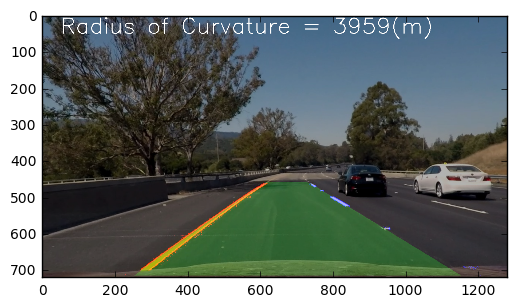

In [9]:
# Run this cell to test the pipeline on a single image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

# Unpack camera calibration data
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define initial region of interest
vertices = np.array([[(110,719), (625, 430), (680, 430), (1260, 719)]], dtype=np.int32)
new_dict = {'vertices':vertices}

# Create some new Line objects
left_line = Line()
right_line = Line()

%matplotlib inline

img = mpimg.imread('../images_video/bridge_trees_example.jpg')
out = process_image(img)
plt.imshow(out)#, cmap='gray')


In [12]:
# Run this cell to watch the video processing frame by frame in an OpenCV window 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib qt

# Unpack camera calibration data
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define initial region of interest
vertices = np.array([[(110,719), (625, 430), (680, 430), (1260, 719)]], dtype=np.int32)
new_dict = {'vertices':vertices}

# Create some new Line objects
left_line = Line()
right_line = Line()

# Start up OpenCV window
cv2.startWindowThread()
cv2.namedWindow('Lane-Finding')
cv2.moveWindow('Lane-Finding', 0, 0)

#cv2.namedWindow('Lane-Finding2')
#cv2.moveWindow('Lane-Finding2', 640, 0)

#cv2.namedWindow('Lane-Finding3')
#cv2.moveWindow('Lane-Finding3', 0, 400)

#cap = cv2.VideoCapture('../images_video/Full_frame_Highway.mp4')
cap = cv2.VideoCapture('../images_video/bridge_shadow_Highway.mp4')
#cap = cv2.VideoCapture('../images_video/curvy_mountain.mp4')
#cap = cv2.VideoCapture('../images_video/highway_85.mp4')

while cap.isOpened():

    ret, image = cap.read()
    if image is not None:
        output = process_image(image)
        reout = cv2.resize(output, (640, 360))
        cv2.imshow('Lane-Finding', reout)
    
    else:
        break
        
    k = cv2.waitKey(30) & 0xff
    if k == 27 :
        break

cap.release()
cv2.destroyAllWindows()

initializing search for left line...
initializing search for the right line...


In [ ]:
# Run this cell to process an entire video with moviepy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Unpack camera calibration data
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define initial region of interest
vertices = np.array([[(110,719), (625, 430), (680, 430), (1260, 719)]], dtype=np.int32)
new_dict = {'vertices':vertices}

# Create some new Line objects
left_line = Line()
right_line = Line()

test_output = 'test.mp4'
clip = VideoFileClip("../images_video/challenge.mp4")
#clip = VideoFileClip("../images_video/bridge_shadow_Highway.mp4")
#clip = VideoFileClip("../images_video/curvy_mountain.mp4")
test_clip = clip.fl_image(process_image)
#%time 
test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))